## Analysis and Filtering of Sulindac metabolism data

##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 1.0 06-10-2021

##### Description:  
This notebook was developed to:
1. Read in NTA WebAPP data for in vitro metabolism data of parent
2. Summarize the distribution of samples replicates
3. Identify annotated features and plot their time trends relative to the parent's signal
4. Filter the number features based on correlation between feature and the parents's signal

##### Notes: This script uses os, pandas, numpy, matplotlib, rdkit, scipy, and Model_Comp

##### Potential issues: *None known*




## Table of Contents

1) Initialize
2) Read and Prepare Data
3) Filter on FC
4) 

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
import networkx as nx
import scipy as scipy
import os
import seaborn as sns
import math
import warnings
import math

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn import preprocessing

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

from rdkit import Chem
warnings.filterwarnings('ignore')

#### Set general variables related to in vitro data

In [81]:
timePoints = [0,1,4]
sampleConditions = ['Super','Gluc','Pellet']
parentFormula = 'C20H17FO3S'

#### Set directory
- RootDir: Where the project is stored
- figDir: Where figures will be stored
- ResultDir: Where the final feature list will be stored

In [82]:
rootDir = r'L:\Lab\NCCT_ExpoCast\ExpoCast2020\SSA-Metabolism\CaseStudy\Sulindac_CaseStudy'
figDir = rootDir + '\Figures\DataReview'
if not os.path.exists(figDir):
    os.makedirs(figDir)
    
resultDir = rootDir + r'\Filtered_features'
if not os.path.exists(resultDir):
    os.makedirs(resultDir)

In [83]:
cluster_list = list(range(1, 10+1))

In [84]:
cluster_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Set helper functions

In [85]:
def optimize_kmeans(input_df, input_clusters):
    cluster_list = list(range(1, input_clusters+1))
    wcss = []
    sil = []
    
    for cluster in cluster_list:
        kmeans = KMeans(n_clusters=cluster, random_state=0).fit(input_df)
        wcss.append(kmeans.inertia_)
        try:
            ss = silhouette_score(input_df, kmeans.labels_ , metric = 'euclidean')
        except:
            ss = 0
        sil.append(ss)
        
    fig, ax1 = plt.subplots(figsize=(6,6))

    ax1.plot(range(1, input_clusters+1), wcss)
    ax2 = ax1.twinx()
    ax2.plot(range(1, input_clusters+1), sil, color = 'red')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.show()
    return(wcss)

# This performs clustering at the feature level (or whatever is separated into rows in the input excel file)
# It takes in the input file, and the desired k number of clusters to perform k means clustering with (i.e. the optimized value from the optimize_kmeans function/elbow method)

def do_kmeans_feature(input_df, input_clusters):
    #Cluster the data
    kmeans = KMeans(n_clusters=input_clusters, n_init=100, random_state=0).fit(input_df)
    labels = kmeans.labels_
    index_list = input_df.index.tolist()
    return_df = pd.DataFrame()
    return_df['Feature_ID'] = index_list
    return_df['Feature_ID'] = return_df['Feature_ID'].astype(int)
    return_df['kmeans_cluster'] = labels

    return(return_df)

# This performs clustering at the sample level (or whatever is separated into columns in the input excel file)
# It takes in the input file, and the desired k number of clusters to perform k means clustering with (i.e. the optimized value from the optimize_kmeans function/elbow method)

def do_kmeans_sample(input_df, input_clusters):
    #Cluster the data
    kmeans = KMeans(n_clusters=input_clusters, n_init=100, random_state=0).fit(input_df)
    labels = kmeans.labels_
    index_list = input_df.index.tolist()
    return_df = pd.DataFrame()
    return_df['Feature_ID'] = index_list
    return_df['kmeans_cluster'] = labels
    
    return(return_df)

In [86]:
def CatchZeroDivision(x,y):
    xf = float(x)
    yf = float(y)
    if(xf==0 and yf==0):
        return 1
    elif(xf == 0):
        return -math.inf
    elif(yf == 0):
        return math.inf
    else:
        return xf/yf
    
def CatchZeroDivision_Series(x_series,y_series):
    returnList = []
    for x,y in zip(x_series, y_series):
        returnList.append(CatchZeroDivision(x, y))
    return returnList

In [87]:
def plotClusterMap(dataToPlot, n_clusters, annotatedDF, column_annotations = True, parentFormula = None, *args, **kwargs):
    
    sns.set(font_scale=1)
    columnsToPlot = dataToPlot.columns
    
    kmeans = KMeans(n_clusters= n_clusters, n_init=100, random_state=0).fit(dataToPlot)
    clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(dataToPlot)
    
    dataToPlot['kmeans'] = kmeans.labels_
    dataToPlot['clustering'] = clustering.labels_
    dataToPlot['Annotated'] = (annotatedDF['Formula'].apply(lambda x: '_mfg' not in x)).astype(int) + (annotatedDF['Formula'] == parentFormula).astype(int)

    dataToPlot.sort_values(by = ['kmeans', 'clustering'], inplace = True)
    
    if column_annotations == True:
        lut1 = dict(zip(set(kmeans.labels_), sns.hls_palette(len(set(kmeans.labels_)), l=0.5, s=1)))
        lut2 = dict(zip(set(dataToPlot['Annotated'] ), sns.hls_palette(len(set(dataToPlot['Annotated'] )), l = 0.5, s = 0.5, h = 0.3)))
        kwargs['row_colors'] = [dataToPlot['kmeans'].map(lut1), dataToPlot['Annotated'].map(lut2)]
    
    g = sns.clustermap(dataToPlot[columnsToPlot], **kwargs)
    


### Import Data
- rawDataFile: Output of the NTA WebApp, after individual conditions are merged into a single csv
- screeningDataFile: File containing all suspected metabolites of Haloperidol used for feature annotation

In [88]:
rawDataFile = rootDir + r'\WebApp_Combined\WebApp_Results_combined.csv'
rawData = pd.read_csv(rawDataFile)

### Read-in and review data

In [89]:
rawData

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
0,87,C10H7ClNO2_mfg,65.19,208.0166,13.322004,26635.0,15341.0,10971.0,537134.0,373027.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,254,C11H14O17_mfg,81.62,418.0201,0.868000,NaN,31627.0,29063.0,110113.0,32944.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,109,C11H6O6_mfg,82.44,234.0166,13.479003,NaN,NaN,NaN,55039.0,54158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,698,C14H30N11_mfg,84.22,352.2660,10.998999,NaN,NaN,NaN,403189.0,166021.0,...,215794.0,62318.0,355334.0,401286.0,410843.0,338968.0,338968.0,0,0,NaN
4,669,C14H33N6_mfg,85.62,285.2726,10.684999,NaN,NaN,NaN,280702.0,91613.0,...,56841.0,28231.0,275030.0,1269463.0,327793.0,270952.0,270952.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,100,C15H10O2_mfg,63.24,222.0691,5.298001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39564.0,52007.0,42058.0,42058.0,42058.0,0,0,NaN
222,175,C15H12N5O3_mfg,73.47,310.0920,1.313000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,78134.0,108887.0,102498.0,102498.0,102498.0,0,1,153(NH4);
223,324,C31H50N7_mfg,76.39,520.4138,12.984004,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,70493.0,77547.0,64800.0,70493.0,70493.0,0,0,NaN
224,440,C43H32O12_mfg,84.39,740.1885,5.872998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29910.0,84013.0,37168.0,37168.0,37168.0,0,0,NaN


In [90]:
rawData[rawData['Formula'] == parentFormula]

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
11,702,C20H17FO3S,58.14,356.0959,7.75,NaN,NaN,NaN,1330985.0,2112691.0,...,NaN,NaN,4207356.0,4892884.0,4307351.0,4307351.0,4307351.0,0,0,NaN


#### Remove adducts from data

In [91]:
rawData = rawData[rawData['Is_Adduct_or_Loss'] == 0]
rawData

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
0,87,C10H7ClNO2_mfg,65.19,208.0166,13.322004,26635.0,15341.0,10971.0,537134.0,373027.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,254,C11H14O17_mfg,81.62,418.0201,0.868000,NaN,31627.0,29063.0,110113.0,32944.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,109,C11H6O6_mfg,82.44,234.0166,13.479003,NaN,NaN,NaN,55039.0,54158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,698,C14H30N11_mfg,84.22,352.2660,10.998999,NaN,NaN,NaN,403189.0,166021.0,...,215794.0,62318.0,355334.0,401286.0,410843.0,338968.0,338968.0,0,0,NaN
4,669,C14H33N6_mfg,85.62,285.2726,10.684999,NaN,NaN,NaN,280702.0,91613.0,...,56841.0,28231.0,275030.0,1269463.0,327793.0,270952.0,270952.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,113,C14H9ClNO_mfg,90.33,242.0360,1.052001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,259359.0,189185.0,167691.0,189185.0,189185.0,0,0,NaN
221,100,C15H10O2_mfg,63.24,222.0691,5.298001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,39564.0,52007.0,42058.0,42058.0,42058.0,0,0,NaN
223,324,C31H50N7_mfg,76.39,520.4138,12.984004,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,70493.0,77547.0,64800.0,70493.0,70493.0,0,0,NaN
224,440,C43H32O12_mfg,84.39,740.1885,5.872998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29910.0,84013.0,37168.0,37168.0,37168.0,0,0,NaN


#### Remove features that are only present at a single time point for any condition

In [92]:
filterByTimeCount = [False] * len(rawData)
medianColumns = [x for x in rawData.columns if 'BlankSub_Median_' in x]
for condition in sampleConditions:
    columns = [x for x in medianColumns if condition in x]
    filterByTimeCount = filterByTimeCount | rawData[columns].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1)

In [93]:
rawData = rawData[filterByTimeCount]
rawData

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
1,254,C11H14O17_mfg,81.62,418.0201,0.868000,NaN,31627.0,29063.0,110113.0,32944.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,109,C11H6O6_mfg,82.44,234.0166,13.479003,NaN,NaN,NaN,55039.0,54158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,669,C14H33N6_mfg,85.62,285.2726,10.684999,NaN,NaN,NaN,280702.0,91613.0,...,56841.0,28231.0,275030.0,1269463.0,327793.0,270952.0,270952.0,0,0,NaN
5,706,C15H31N6O4_mfg,82.43,359.2373,10.296998,NaN,NaN,NaN,541563.0,356447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
7,213,C17H24N7O2_mfg,89.21,358.1981,10.152004,67074.0,NaN,112139.0,2033858.0,824636.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,902,C38H81N2O12_mfg,99.34,757.5893,12.984991,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
202,926,C39H71N15O2_mfg,68.99,781.5934,12.890996,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
203,924,C43H83N5O3S2_mfg,90.12,781.5859,12.888997,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
205,28,C6H6N2O2_mfg,87.16,138.0431,1.307999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


#### Consolidate data based on hour and condition, and sum the number of replicates measured

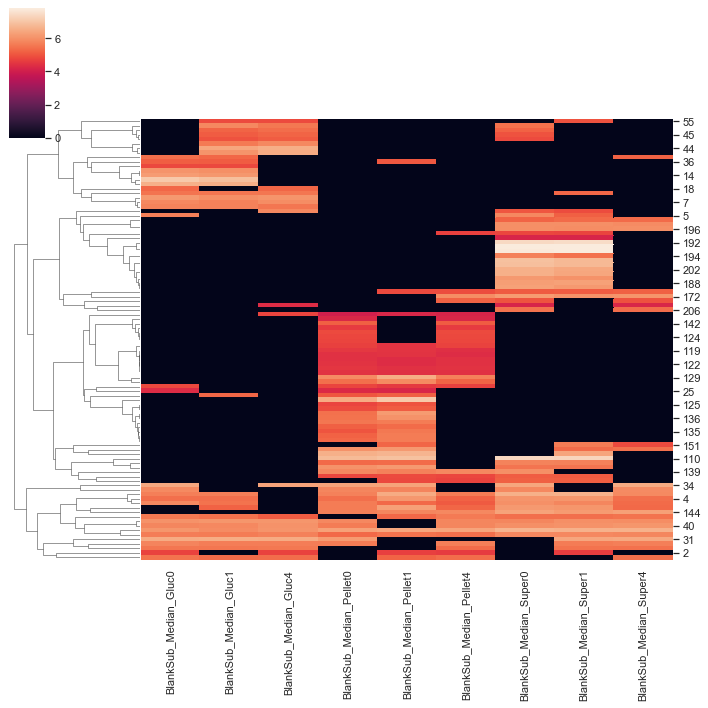

In [94]:
clusterData = rawData[[col for col in rawData.columns if 'BlankSub_Median_' in col]].fillna(1)
clusterFigure = sns.clustermap(np.log10(clusterData), col_cluster=False)
plt.savefig(figDir + r'\SampleDistribution.png')

## Tracking Annotated Features

In [95]:
annotatedFeatures = [feature for feature in rawData['Formula'] if '_mfg' not in feature]
annotatedFeatures

['C20H17FO3S', 'C20H19FO5S', 'C26H25FO11S', 'C20H17FO5S']

In [96]:
parentDataAll = rawData.loc[rawData['Formula'] == parentFormula,]
parentData = rawData.loc[rawData['Formula'] == parentFormula,['BlankSub_Median_Super0','BlankSub_Median_Super1','BlankSub_Median_Super4',
                                                            'BlankSub_Median_Gluc0','BlankSub_Median_Gluc1','BlankSub_Median_Gluc4',
                                                            'BlankSub_Median_Pellet0','BlankSub_Median_Pellet1','BlankSub_Median_Pellet4',]].values

In [97]:
parentDataAll

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
11,702,C20H17FO3S,58.14,356.0959,7.75,NaN,NaN,NaN,1330985.0,2112691.0,...,NaN,NaN,4207356.0,4892884.0,4307351.0,4307351.0,4307351.0,0,0,NaN


In [98]:
featureDF = rawData[rawData['Formula'].isin(annotatedFeatures)]
metabDF = featureDF[featureDF['Formula'] != parentFormula].reset_index()

In [99]:
metabDF

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
0,12,722,C20H19FO5S,71.77,390.0947,5.285999,NaN,NaN,NaN,519130.0,...,NaN,NaN,695085.0,841269.0,718711.0,718711.0,718711.0,0,0,NaN
1,122,373,C26H25FO11S,73.90,610.1152,0.883000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,152,237,C20H17FO5S,91.93,388.0799,5.898999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [100]:
dbAnnotation_Filter = rawData['Formula'].apply(lambda x: '_mfg' not in x)
metab_Filter = (dbAnnotation_Filter) & (rawData['Formula'].apply(lambda x: x != parentFormula))

### Clean and Prepare Data

#### Impute and Normalize data

In [101]:
noiseValue = 10000

In [102]:
dataColumns = ['BlankSub_Median_Super0', 'BlankSub_Median_Super1', 'BlankSub_Median_Super4',
               'BlankSub_Median_Gluc0', 'BlankSub_Median_Gluc1', 'BlankSub_Median_Gluc4',
               'BlankSub_Median_Pellet0', 'BlankSub_Median_Pellet1', 'BlankSub_Median_Pellet4']

In [103]:
noiseImpute = rawData[dataColumns].replace(np.nan, 10000.0).copy()
noiseImpute_transform = noiseImpute.apply(lambda x: np.log2(x), axis = 1)
noiseImpute_normalized = noiseImpute_transform.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

In [104]:
noiseImpute.describe()

,BlankSub_Median_Super0,BlankSub_Median_Super1,BlankSub_Median_Super4,BlankSub_Median_Gluc0,BlankSub_Median_Gluc1,BlankSub_Median_Gluc4,BlankSub_Median_Pellet0,BlankSub_Median_Pellet1,BlankSub_Median_Pellet4
count,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01
mean,2.392954e+06,2.375866e+06,2.452607e+05,3.896793e+05,3.350568e+05,2.521384e+05,3.304851e+05,5.673780e+05,1.161135e+05
std,9.394325e+06,9.776675e+06,6.654667e+05,1.366881e+06,1.007350e+06,6.835220e+05,9.004008e+05,1.736209e+06,3.018125e+05
min,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
25%,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
50%,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.060800e+04,1.000000e+04,1.000000e+04
75%,7.469078e+05,6.543055e+05,9.261525e+04,1.947302e+05,2.063300e+05,5.796250e+04,2.177338e+05,2.244212e+05,5.641475e+04
max,6.439308e+07,6.451220e+07,4.307351e+06,1.210918e+07,8.159350e+06,3.872416e+06,6.519145e+06,1.280995e+07,2.408030e+06


In [105]:
fcImpute = rawData.loc[:,dataColumns].replace(np.nan, 0.0).copy()
for condition in sampleConditions:
    fcImpute[[x for x in fcImpute.columns if condition in x]] =  fcImpute[[x for x in fcImpute.columns if condition in x]].apply(lambda x: CatchZeroDivision_Series(x, fcImpute['BlankSub_Median_'+condition+'0']))

In [106]:
fcLowImputeValues = fcImpute.apply(lambda x: min(x.replace(-math.inf, 10000)), axis = 0)
fcHighImputeValues = fcImpute.apply(lambda x: max(x.replace(math.inf, -10000)), axis = 0)

fcImpute = fcImpute.replace(-math.inf, min(fcLowImputeValues)).replace(math.inf, max(fcHighImputeValues))

In [107]:
minFCValue = 1.5
minFC_Filter = fcImpute.apply(lambda row: max(row) >= minFCValue, axis = 1)
minFCParent_Filter = (minFC_Filter) | (rawData['Formula'] == parentFormula)

In [108]:
fcImpute_transform = fcImpute.apply(lambda x: np.log2(x), axis = 1)
fcImpute_normalized = fcImpute_transform.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

In [109]:
fcImpute.describe()

,BlankSub_Median_Super0,BlankSub_Median_Super1,BlankSub_Median_Super4,BlankSub_Median_Gluc0,BlankSub_Median_Gluc1,BlankSub_Median_Gluc4,BlankSub_Median_Pellet0,BlankSub_Median_Pellet1,BlankSub_Median_Pellet4
count,98.0,98.000000,98.000000,98.0,98.000000,98.000000,98.0,98.000000,98.000000
mean,1.0,1.303937,1.087834,1.0,1.380906,1.390528,1.0,1.614111,1.233191
std,0.0,1.409803,1.324735,0.0,1.456945,1.546048,0.0,1.558751,1.449389
min,1.0,0.149250,0.149250,1.0,0.149250,0.149250,1.0,0.149250,0.149250
25%,1.0,0.920512,0.149250,1.0,1.000000,1.000000,1.0,1.000000,0.694718
50%,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000
75%,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.364775,1.000000
max,1.0,5.625590,5.625590,1.0,5.625590,5.625590,1.0,5.625590,5.625590


#### Filter on Fold-Change: remove features that have a fc > 1.5 for any condition and at least two measurements in that condition

In [110]:
columnGroups = []
for condition in sampleConditions:
    columnGroups +=  [[x for x in medianColumns if condition in x]]

In [111]:
filterConditionDF = pd.DataFrame()
filterConditionDF['Super'] = rawData[columnGroups[0]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) &  fcImpute[columnGroups[0]].apply(lambda row: max(row) >= minFCValue, axis = 1)
filterConditionDF['Gluc'] = rawData[columnGroups[1]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) & fcImpute[columnGroups[1]].apply(lambda row: max(row) >= minFCValue, axis = 1)
filterConditionDF['Pellet'] = rawData[columnGroups[2]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) & fcImpute[columnGroups[2]].apply(lambda row: max(row) >= minFCValue, axis = 1)

In [112]:
FCandSampleCountFilter = (filterConditionDF.apply(lambda x: bool(sum(x)), axis = 1)) | (rawData['Formula']==parentFormula)

In [113]:
sum(FCandSampleCountFilter)

34

In [114]:
rawData_FCFilter =  rawData[FCandSampleCountFilter].copy().reset_index()
rawData_FCParentFilter =  rawData[FCandSampleCountFilter].copy().reset_index()
metabDF_FCFilter = rawData[(FCandSampleCountFilter & metab_Filter)].copy().reset_index()

In [115]:
rawData[(minFC_Filter & dbAnnotation_Filter) | (rawData['Formula']==parentFormula)]

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
11,702,C20H17FO3S,58.14,356.0959,7.750000,NaN,NaN,NaN,1330985.0,2112691.0,...,NaN,NaN,4207356.0,4892884.0,4307351.0,4307351.0,4307351.0,0,0,NaN
152,237,C20H17FO5S,91.93,388.0799,5.898999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


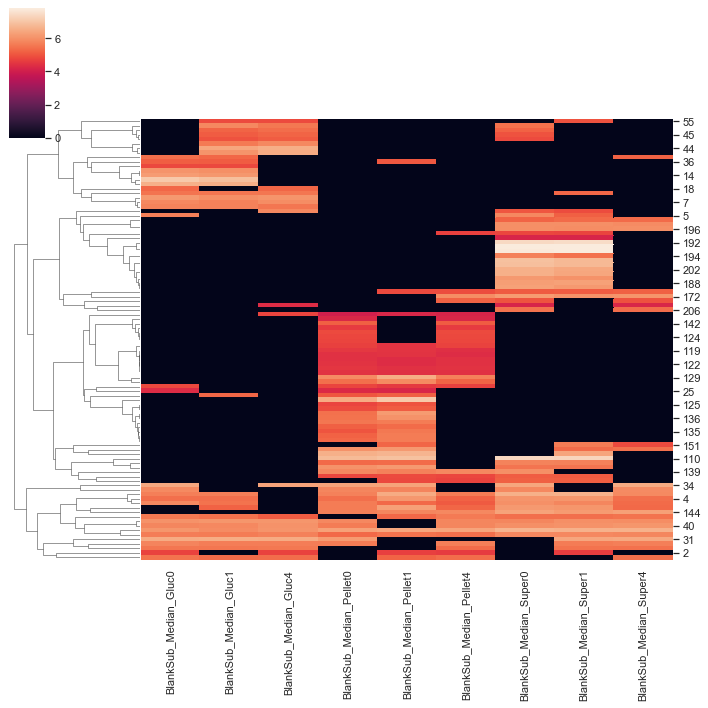

In [116]:
clusterData_FC = rawData_FCFilter[[col for col in rawData.columns if 'BlankSub_Median_' in col]].fillna(1)
clusterFigure = sns.clustermap(np.log10(clusterData), col_cluster=False)

## Tracking Parent Response

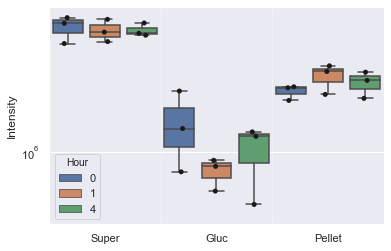

In [117]:
columns = ['Super00', 'Super01', 'Super02', 'Super10', 'Super11', 'Super12', 'Super40', 'Super41', 'Super42', 'Gluc00', 'Gluc01', 'Gluc02', 'Gluc10', 'Gluc11', 'Gluc12', 'Gluc40', 'Gluc41', 'Gluc42', 'Pellet00', 'Pellet01', 'Pellet02', 'Pellet10', 'Pellet11', 'Pellet12', 'Pellet40', 'Pellet41', 'Pellet42']
conditionGroups = [x[:-1] for x in columns]
timeGroups = [x[-2] for x in columns]

plotDF = pd.DataFrame()
plotDF['Condition'] = conditionGroups
plotDF['Intensity'] = parentDataAll[columns].values[0]
plotDF['Hour'] = timeGroups

ax = sns.boxplot(data = plotDF, x = 'Condition', y = 'Intensity', hue = 'Hour', dodge=False, whis=np.inf)
ax = sns.stripplot(data = plotDF, x = 'Condition', y = 'Intensity', color = ".1")

ax.set_xlabel('')
ax.set_yscale("log")
ax.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])


ax.add_patch(mpatches.Rectangle((0, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
ax.add_patch(mpatches.Rectangle((1/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
ax.add_patch(mpatches.Rectangle((2/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 

plt.savefig(figDir+'\parent_boxplot.png', dpi = 300)

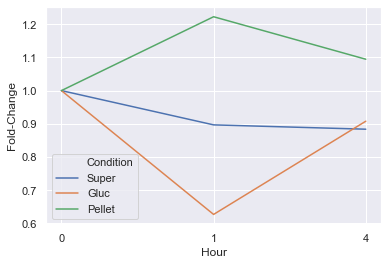

In [118]:
plotDF = fcImpute[rawData['Formula'] == parentFormula].transpose()
plotDF['Condition'] = [x.split("_")[-1][:-1] for x in plotDF.index]
plotDF['Hour'] = [x[-1] for x in plotDF.index]

ax = sns.lineplot(data = plotDF, x = 'Hour', y = plotDF.columns[0], hue = 'Condition')

ax.set_ylabel('Fold-Change')
#ax.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])
#ax.xaxis.set_major_locator(plt.FixedLocator([1,4,7]))

plt.savefig(figDir+'\Sulindac_fc.png', dpi = 300)

### Data Analysis: K-means clustering of filtered features

#### K-means clustering

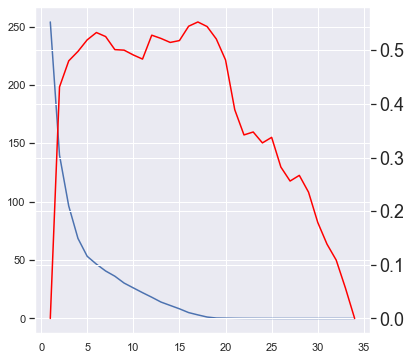

<Figure size 432x288 with 0 Axes>

In [119]:
test_optimize = optimize_kmeans(noiseImpute_normalized[FCandSampleCountFilter], 34)
plt.savefig(figDir+'\kmeans_opti_noiseImpute.png', dpi = 300)

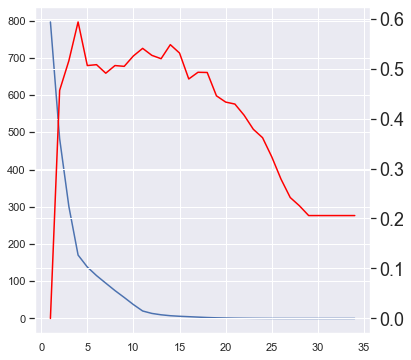

<Figure size 432x288 with 0 Axes>

In [120]:
test_optimize = optimize_kmeans(fcImpute[FCandSampleCountFilter], 34)
plt.savefig(figDir+'\kmeans_opti_FC.png', dpi = 300)

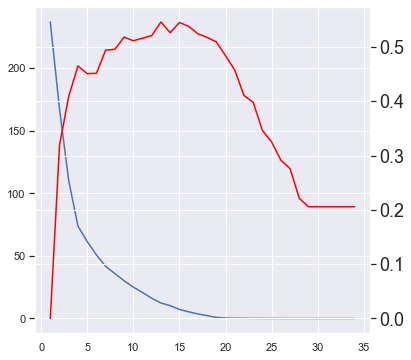

In [121]:
test_optimize = optimize_kmeans(fcImpute_normalized[FCandSampleCountFilter], 34)

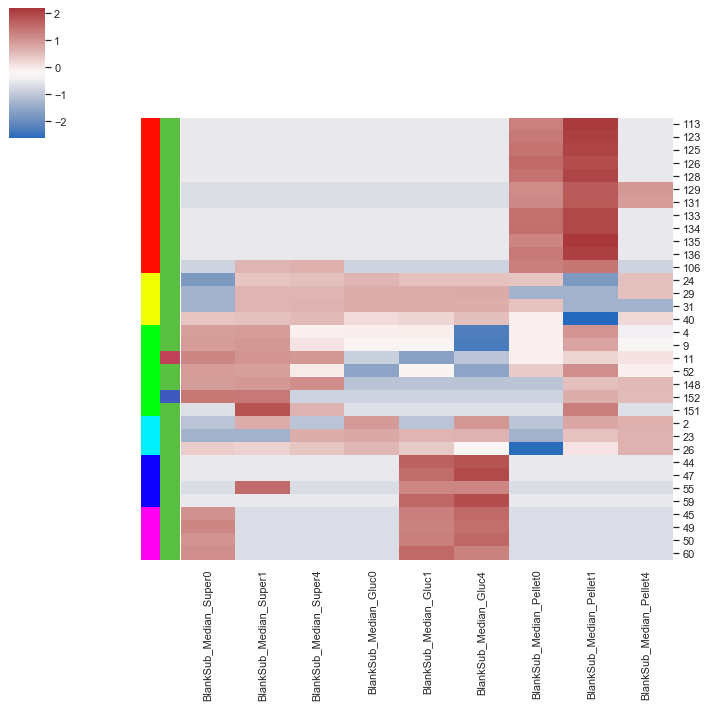

In [132]:
plotClusterMap(noiseImpute_normalized[FCandSampleCountFilter], 6, rawData, cmap='vlag', parentFormula = parentFormula, row_cluster = False, col_cluster = False)
plt.savefig(r'C:\Users\MBOYCE\OneDrive - Environmental Protection Agency (EPA)\Profile\Documents\cluster_noiseImpute.png', dpi = 300)

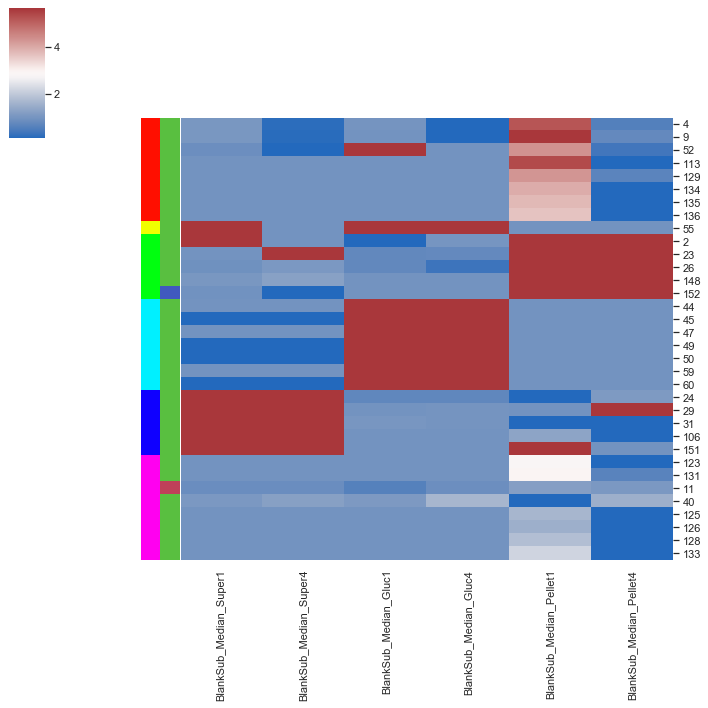

In [133]:
plotClusterMap(fcImpute.loc[FCandSampleCountFilter, [x for x in fcImpute.columns if 'BlankSub_Median_' in x and '0' not in x]], 6, rawData, cmap='vlag', parentFormula = parentFormula, row_cluster = False, col_cluster = False)

### Features in K-means cluster

In [137]:
kmeans = KMeans(n_clusters= 5, n_init=100, random_state=0).fit(noiseImpute_normalized[FCandSampleCountFilter])

In [138]:
rawData_FCParentFilter['KMeans'] = kmeans.labels_
rawData_FCParentFilter[rawData_FCParentFilter['Formula'].apply(lambda x: '_mfg' not in x)]

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,KMeans
3,11,702,C20H17FO3S,58.14,356.0959,7.750000,NaN,NaN,NaN,1330985.0,...,NaN,4207356.0,4892884.0,4307351.0,4307351.0,4307351.0,0,0,NaN,2
33,152,237,C20H17FO5S,91.93,388.0799,5.898999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,2


#### Filter data using KMeans clusters

In [139]:
kmeansToFilterOn = list(set(rawData_FCParentFilter.loc[(rawData_FCParentFilter['Formula'].apply(lambda x: '_mfg' not in x)) & (~rawData_FCParentFilter['Formula'].str.contains(parentFormula)), 'KMeans']))
rawData_FCParentFilter.loc[rawData_FCParentFilter['KMeans'].isin(kmeansToFilterOn)|(rawData_FCParentFilter['Formula'].str.contains(parentFormula)),['Formula', 'Mass', 'Retention_Time', 'KMeans']].sort_values(by = 'Retention_Time')

,Formula,Mass,Retention_Time,KMeans
31,C14H2N_mfg,184.0195,3.106001,2
33,C20H17FO5S,388.0799,5.898999,2
3,C20H17FO3S,356.0959,7.750000,2
1,C14H33N6_mfg,285.2726,10.684999,2
2,C17H39N6_mfg,327.3197,10.885993,2
15,C19H39NO2_mfg,313.3098,11.085000,2
32,C19H43N6_mfg,355.3539,11.282001,2


In [140]:
subset = rawData_FCParentFilter.loc[rawData_FCParentFilter['KMeans'].isin(kmeansToFilterOn)|(rawData_FCParentFilter['Formula'] == parentFormula),:].sort_values(by = 'Retention_Time').copy()
subset['Formula'] = [x.split(str(y)[:3])[0] + '_mfg' if str(y)[:3] in x else x for x, y in zip(subset['Formula'], subset['Retention_Time'])]
subset.reset_index(inplace = True, drop = True)
subset.sort_values(by = 'KMeans')
subset.to_csv(resultDir + '\FeatureList_subset.csv', index = False)

In [141]:
subset

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,KMeans
0,148,65,C14H2N_mfg,78.75,184.0195,3.106001,NaN,NaN,NaN,NaN,...,NaN,157792.0,179226.0,162179.0,162179.0,162179.0,0,0,NaN,2
1,152,237,C20H17FO5S,91.93,388.0799,5.898999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,2
2,11,702,C20H17FO3S,58.14,356.0959,7.750000,NaN,NaN,NaN,1330985.0,...,NaN,4207356.0,4892884.0,4307351.0,4307351.0,4307351.0,0,0,NaN,2
3,4,669,C14H33N6_mfg,85.62,285.2726,10.684999,NaN,NaN,NaN,280702.0,...,28231.0,275030.0,1269463.0,327793.0,270952.0,270952.0,0,0,NaN,2
4,9,684,C17H39N6_mfg,75.84,327.3197,10.885993,NaN,NaN,NaN,518961.0,...,152358.0,722933.0,4192018.0,979653.0,808571.0,808571.0,0,0,NaN,2
5,52,681,C19H39NO2_mfg,82.59,313.3098,11.085000,NaN,NaN,NaN,NaN,...,NaN,198264.0,972896.0,218556.0,218556.0,218556.0,0,0,NaN,2
6,151,701,C19H43N6_mfg,76.77,355.3539,11.282001,NaN,NaN,NaN,NaN,...,NaN,48983.0,515021.0,74811.0,74811.0,74811.0,0,0,NaN,2


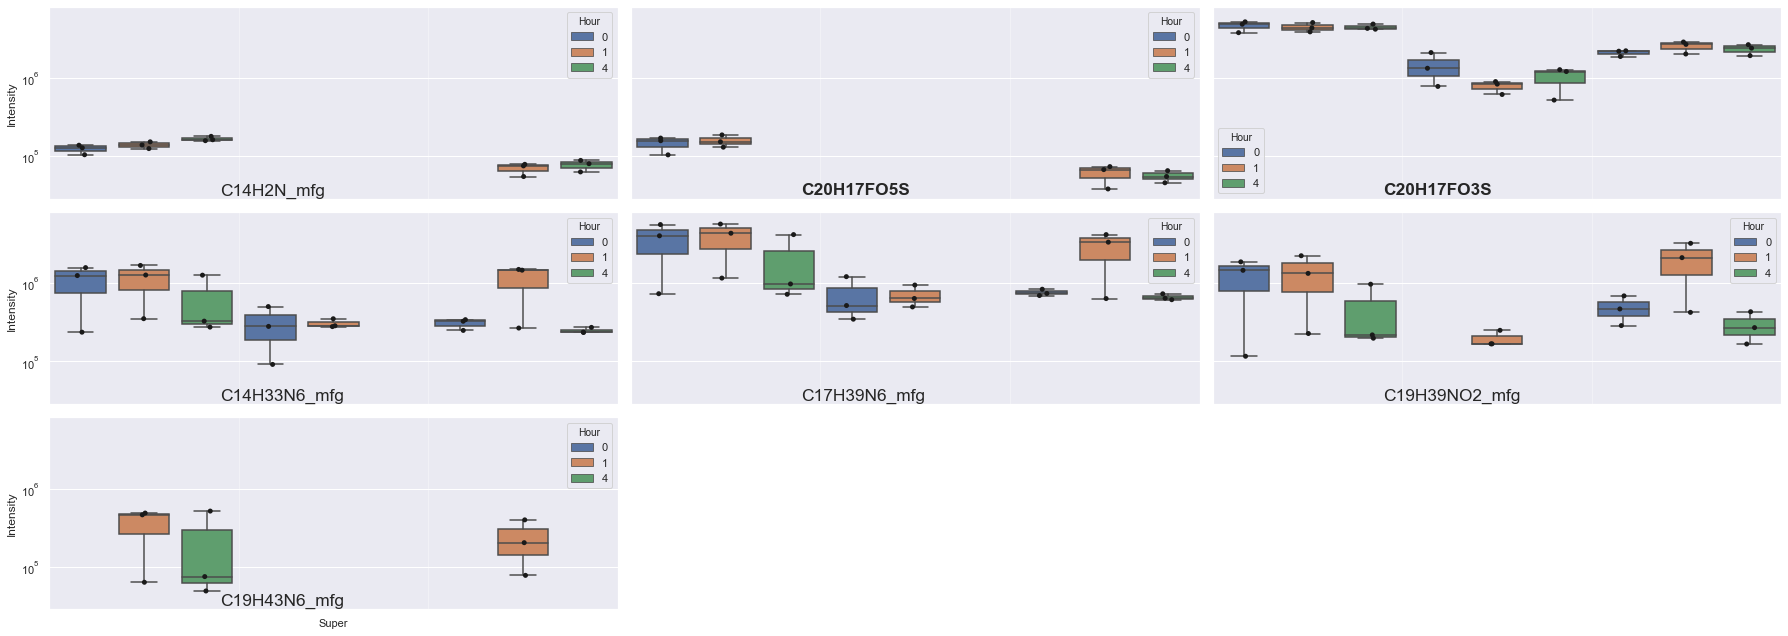

In [142]:
columns = ['Super00', 'Super01', 'Super02', 'Super10', 'Super11', 'Super12', 'Super40', 'Super41', 'Super42', 'Gluc00', 'Gluc01', 'Gluc02', 'Gluc10', 'Gluc11', 'Gluc12', 'Gluc40', 'Gluc41', 'Gluc42', 'Pellet00', 'Pellet01', 'Pellet02', 'Pellet10', 'Pellet11', 'Pellet12', 'Pellet40', 'Pellet41', 'Pellet42']
conditionGroups = [x[:-1] for x in columns]
timeGroups = [x[-2] for x in columns]
x = conditionGroups
lut = dict(zip(set(timeGroups), sns.hls_palette(len(set(timeGroups)))))
numCols = int(len(subset)/2)
numRows = math.ceil(len(subset)/numCols)
numPlots = len(subset)
fig, axes = plt.subplots(numRows, numCols, figsize = (25,int(numRows*3)), sharex = True, sharey = True)
[ax.set_axis_off() for ax in axes.ravel()]

for dfIdx, row in subset.iterrows():
    plotDF = pd.DataFrame()
    plotDF['Condition'] = conditionGroups
    plotDF['Intensity'] = row[columns].values
    plotDF['Hour'] = timeGroups
    
    subplotRow = math.floor(dfIdx/numCols)
    subplotCol = dfIdx - (numCols * subplotRow)
    
    axes[subplotRow, subplotCol].set_axis_on()
    
    ax = sns.boxplot(data = plotDF, x = 'Condition', y = 'Intensity', hue = 'Hour' , ax = axes[subplotRow, subplotCol], dodge=False, whis=np.inf)
    ax = sns.stripplot(data = plotDF, x = 'Condition', y = 'Intensity', ax = axes[subplotRow, subplotCol], color = ".1")
    
    ax.text(0.3, 0.02, row['Formula'], transform=ax.transAxes, fontsize = 'x-large', fontweight = 'regular' if '_mfg' in row['Formula'] else 'bold')
    ax.set_xlabel('')
    ax.set_yscale("log")
    ax.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])
    ax.xaxis.set_major_locator(plt.FixedLocator([1,4,7]))
    
    if subplotCol != 0:
        ax.set_ylabel('')
        ax.set_yticks([], minor=False)
        #axes[subplotRow, subplotCol].tick_params(left = False)
        #axes[subplotRow, subplotCol].minorticks_off()
        
    if subplotRow != 0:
        ax.tick_params(top = False)
    
    ax.add_patch(mpatches.Rectangle((0, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
    ax.add_patch(mpatches.Rectangle((1/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
    ax.add_patch(mpatches.Rectangle((2/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 

fig.tight_layout()
plt.savefig(r'C:\Users\MBOYCE\OneDrive - Environmental Protection Agency (EPA)\Profile\Documents\\SelectedFeature_boxplot.png', dpi = 300)

In [ ]:
figDir

### Feature List

In [53]:
rawData_FCParentFilter[rawData_FCParentFilter['KMeans'].isin(kmeansToFilterOn)].to_csv("C:\\Users\\MBOYCE\\OneDrive - Environmental Protection Agency (EPA)\\Profile\\Documents\\FeatureList.csv")

### Correlation Map

In [114]:
corrData = rawData[['BlankSub_Median_Super0','BlankSub_Median_Super1','BlankSub_Median_Super4',
                                                            'BlankSub_Median_Gluc0','BlankSub_Median_Gluc1','BlankSub_Median_Gluc4',
                                                            'BlankSub_Median_Pellet0','BlankSub_Median_Pellet1','BlankSub_Median_Pellet4']]

In [127]:
corrDF = corrData.T.corr()
links = corrDF.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
links_filtered=links.loc[ ((links['value'] > 0.8) | (links['value'] < -0.8)) & (links['var1'] != links['var2']) ]
links_filtered['var1'] = [rawData.loc[x, 'Formula'] for x in links_filtered['var1']]
links_filtered['var2'] = [rawData.loc[x, 'Formula'] for x in links_filtered['var2']]

In [128]:
links_filtered

,var1,var2,value
1,C10H11FO2,C10H11N7O5_mfg,-1.0
2,C10H11FO2,C10H13NO24.356002_mfg,1.0
3,C10H11FO2,C10H14N3O10_mfg,1.0
4,C10H11FO2,C10H16O55.0989995_mfg,1.0
5,C10H11FO2,C10H18N5O9_mfg,1.0
...,...,...,...
118019,C5H10N2O3_mfg,C18H49N16O2_mfg,-1.0
118020,C5H10N2O3_mfg,C19H38O4_mfg,1.0
118021,C5H10N2O3_mfg,C33H71N16O7_mfg,1.0
118022,C5H10N2O3_mfg,C35H70N18O9_mfg,1.0


In [129]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

In [507]:
import nxviz as nv 
from nxviz import annotate

In [508]:
subset['index']

0    444
1    435
2    411
3     12
4    208
5    192
6     69
7     67
8    132
Name: index, dtype: int64

In [510]:
subsetCorrData = rawData[rawData['Feature_ID'].isin(subset['Feature_ID'])]
subsetCorrData = subsetCorrData[['BlankSub_Median_Super0','BlankSub_Median_Super1','BlankSub_Median_Super4',
                                                            'BlankSub_Median_Gluc0','BlankSub_Median_Gluc1','BlankSub_Median_Gluc4',
                                                            'BlankSub_Median_Pellet0','BlankSub_Median_Pellet1','BlankSub_Median_Pellet4']]
subsetCorrDF = subsetCorrData.T.corr()
subLinks = subsetCorrDF.stack().reset_index()
subLinks.columns = ['var1', 'var2', 'value']
subLinks_filtered=subLinks.loc[ ((subLinks['value'] > 0.5) | (subLinks['value'] < -0.5)) & (subLinks['var1'] != subLinks['var2']) ]
subLinks_filtered['var1'] = [rawData.loc[x, 'Formula'] for x in subLinks_filtered['var1']]
subLinks_filtered['var2'] = [rawData.loc[x, 'Formula'] for x in subLinks_filtered['var2']]

In [511]:
g.nodes()

NodeView(('C11H14ClNO', 'C21H23ClFNO2', 'C9H21N7O_mfg', 'C21H25ClFNO2', 'C27H31ClFNO8', 'C22H20N2O4Esi-0.97700036_mfg', 'C32H67N16O5_mfg', 'C21H18ClFNO', 'C20H2Cl2O22_mfg', 'C19H11N6O3_mfg', 'C14H24O13_mfg', 'C24H47NO_mfg', 'C4H6O5_mfg'))

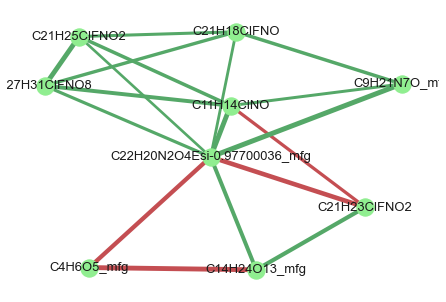

In [512]:
g = nx.Graph()
for idx, row in subLinks_filtered.iterrows():
    g.add_edge(row['var1'],row['var2'],color='r' if row['value'] < 0 else 'g', weight= abs(row['value'])*5)


colors = nx.get_edge_attributes(g,'color').values()
weights = nx.get_edge_attributes(g,'weight').values()

nx.draw(g,
        edge_color=colors, 
        width=list(weights),
        with_labels=True,
        node_color='lightgreen',
        font_size=13)

In [600]:
generation = {}
generation1 = ['C11H14ClNO','C21H25ClFNO2', 'C27H31ClFNO8']
generation2 = ['C21H18ClFNO']
generation3 = []
#Assign Generation
for node in g.nodes():
    if parentFormula == node:
        generation[node] = 0
    elif '_mfg' in node:
        generation[node] = 1
    elif node in generation1:
        generation[node] = 2
    elif node in generation2:
        generation[node] = 3
    elif node in generation3:
        generation[node] = 4

#Count elements per layer
layerCount = [list(generation.values()).count(0),list(generation.values()).count(1), list(generation.values()).count(2), list(generation.values()).count(3), list(generation.values()).count(4)]
maxValue = max(layerCount)
minPerLayer = list(map(lambda x: (maxValue - x)/2, layerCount))
curPos = minPerLayer
curAngle = 0
angle = 360 / (layerCount[1] + 1) / 2
step = 5
center = (step, minPerLayer[0])
pos = {}
print(center)

for node in g.nodes():
    if '_mfg' in node:
        x = center[0] + math.cos(curAngle)
        y = center[1] + 0.25 * math.sin(curAngle)
        pos[node] = (x, y)
        print(x,y)
        curAngle += angle
        continue
    pos[node] = (generation[node] * (step + 1), curPos[generation[node]])
    curPos[generation[node]] = curPos[generation[node]] + 1

(5, 1.5)
6.0 1.5
4.872036310372596 1.2520552866392212
4.032749411726117 1.563455840690509
5.375509597767012 1.7317046263544462


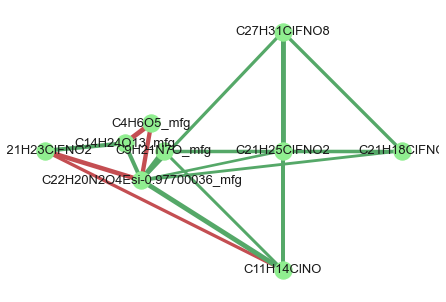

In [601]:
nx.draw(g, pos = pos,
        edge_color=colors, 
        width=list(weights),
        with_labels=True,
        node_color='lightgreen',
        font_size=13)
plt.tight_layout()